# Udacity SDCND Project 5 - Vehicle Tracking 
#### Alistair Kirk - April 20 2017

In [1]:
#Init Libraries
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
% matplotlib inline
import glob

import time

In [2]:
# Create a pandas dataframe of training data
datapath = 'object-detection-crowdai/'
df_files = pd.read_csv(datapath+'labels.csv', header = 0) # Import crowdai training data
df_vehicle = df_files[(df_files['Label']=='Car')|(df_files['Label']=='Truck')].reset_index() # Merge car and truck data
df_vehicle = df_vehicle.drop('index', 1) # Removing redundant index column
df_vehicle['File_Path'] = datapath+df_vehicle['Frame'] # Adding filepath
df_vehicle = df_vehicle.drop('Preview URL',1) # Removing URL
df_vehicle.head() # Preview data frame
#df_vehicle.tail()

,xmin,ymin,xmax,ymax,Frame,Label,File_Path
0,785,533,905,644,1479498371963069978.jpg,Car,object-detection-crowdai/1479498371963069978.jpg
1,89,551,291,680,1479498371963069978.jpg,Car,object-detection-crowdai/1479498371963069978.jpg
2,268,546,383,650,1479498371963069978.jpg,Car,object-detection-crowdai/1479498371963069978.jpg
3,455,522,548,615,1479498371963069978.jpg,Truck,object-detection-crowdai/1479498371963069978.jpg
4,548,522,625,605,1479498371963069978.jpg,Truck,object-detection-crowdai/1479498371963069978.jpg


(400, 480, 3)


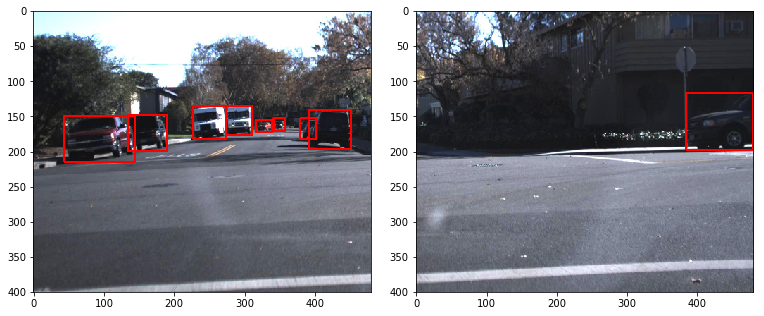

In [3]:
# Define functions to get images and bounding boxes
# The get_bbox function is unique in that it takes an input image, assumed to be a full resolution camera image from the dash
# Then it focuses on the middle third of the image to cutout the hood and sky, and also splits the image horizontally into
# x-split equal segments. For final submission I split into 2 left and right images.
# This was done so that the Neural Network can run on my GTX 770 GPU, with 2GB GPU Memory Limit. 
# Larger input images tend to cause OOM problems

def plot_bboxes(imagelist,bboxlist):
    # Plots the bounding boxes onto your image using CV2
        numimages = len(imagelist)
        f, axes = plt.subplots(1, numimages, figsize=(10, 5))
        f.tight_layout()

        for i in range(numimages):          
            for bboxes_i in bboxlist[i]:                
                if (len(bboxes_i)>0):
                    cv2.rectangle(images[i],(bboxes_i[1],bboxes_i[3]),(bboxes_i[0],bboxes_i[2]),(255,0,0),thickness=2) 

            axes[i].imshow(images[i])
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

def get_bbox(df, ind, xsplit = 4, scale = 1, ylow = 0.125, yfrac = 2/3):
    #Get image at index and split the image
    assert type(xsplit) is int, "Need a whole integer to define a split"
    file_name = df['File_Path'][ind]
    img = cv2.imread(file_name)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img_size = np.shape(img)
    img = cv2.resize(img,(int(scale*img_size[1]), int(scale*img_size[0])), interpolation = cv2.INTER_CUBIC)
    img_size = np.shape(img)
    #print(img_size)
    images = []
    #Find and collect the bounding boxes for this image
    main_bboxes = df[df['Frame'] == ((file_name.split('/'))[-1])].reset_index()
    #main_bboxes.head()
    #print(main_bboxes)
    bboxes = []
    for i in range(xsplit):
        #crop_img = img[200:400, 100:300] # Crop from x, y, w, h -> 100, 200, 300, 400
        # NOTE: its img[y: y + h, x: x + w]
        img_slice = img[int(img_size[0]*(1-(yfrac+ylow))):int(img_size[0]*(1-ylow)),
                            int(i*img_size[1]/xsplit):int((i*img_size[1]/xsplit)+img_size[1]/xsplit)]        
        images.append(img_slice)
        bboxes_i = []
        #find and split bounding boxes if required
        for ibox in range(len(main_bboxes)):
            # Gather the original coordinates and reset y origin depending on the fractions
            xmin = main_bboxes.iloc[ibox]['xmin']*scale
            ymin = main_bboxes.iloc[ibox]['ymin']*scale
            ymin = ymin-(int(img_size[0]*(1-(yfrac+ylow))))
            xmax = main_bboxes.iloc[ibox]['xmax']*scale
            ymax = main_bboxes.iloc[ibox]['ymax']*scale
            ymax = ymax - int(img_size[0]*(1-(yfrac+ylow)))
            
            #Start chopping boxes and add to bboxes
            width = int(img_size[1]/xsplit)
            xstart = int(i*img_size[1]/xsplit)

            if ((xmin<(xstart+width))&(xmin>xstart)):
                #print(xmin, xstart)
                xmin = min(xmin-xstart, xstart+width)
                xmax = min(xmax-xstart-1, xstart+width-1)
                bboxes_i.append([int(xmin),int(xmax),int(ymin),int(ymax)])
            if (xmin<=xstart)&(xmax>(xstart)):
                xmin = 1
                xmax = xmax-xstart
                bboxes_i.append([int(xmin),int(xmax),int(ymin),int(ymax)])
        bboxes.append(bboxes_i) 
    return images,bboxes

# Test the function
images,bboxlist = get_bbox(df_vehicle,1, xsplit=2, scale=0.5)
print(images[0].shape)
#print(bboxes)
plot_bboxes(images,bboxlist)


#### Masking Function

Performing Masking Test and Plotting:
(400, 480, 1)


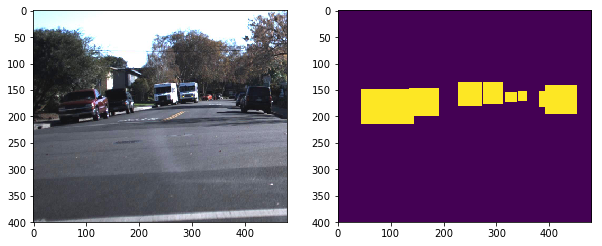

In [4]:
def get_mask(image,bboxes):   
    #Assume you are passing in an image, and the list of bounding boxes; bboxes
    #Generate a 1 layer mask image using the bounding boxes
    mask = np.zeros_like(image[:,:,0])
    for box in bboxes:                
        mask[box[2]:box[3],box[0]:box[1]]= 1.
    mask = np.reshape(mask,(np.shape(mask)[0],np.shape(mask)[1],1))
    #print(mask.shape)
    return mask

print("Performing Masking Test and Plotting:")
images,bboxlist = get_bbox(df_vehicle,1, xsplit=2, scale=0.5)
testmask = get_mask(images[0],bboxlist[0])
print(testmask.shape)
f, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(images[0])
axes[1].imshow(np.array(testmask,dtype=np.uint8)[:,:,0])

#### AssembleTraining Data for Reuse

In [5]:
import pickle
from tqdm import tqdm #library for the progress bar during for loop

# It was faster and easier to load these images into memory using lists.
# Future work should consider either dynamically accessing the images or preprocessing and saving to disk

all_images = []
all_masks = []

#data_save_loc = 'D:/cardata'

total_vehicles = len(df_vehicle)

# Specify the key parameters for preprocessing the images.
# It is important to make the xsplit and scale factor match later on when processing input images of different resolutions
# The number of images used in training is multiplied by the xsplit. Limited by available system memory.
# Future work to dynamically access images instead of preallocating to memory.
num_train = 100 #total_vehicles
xsplit = 2
scale = 0.5

print("Splitting, Scaling, Masking {} Training Images:".format(num_train))

for i in tqdm(range(num_train)):    
    index = i
    #Randomly select the number of images, make sure to comment out if all are needed in sequence
    index = np.random.randint(total_vehicles)
    images,bboxlist = get_bbox(df_vehicle,index, xsplit=xsplit, scale=scale)
    for j in range(len(images)):
        # Create the masks, and add them to the big lists (order matters to pair img/mask!)
        jmask = get_mask(images[j],bboxlist[j])
        all_images.append(images[j])
        all_masks.append(jmask)
        #np.save(data_save_loc + '/images/'+ str(i)+'.npy',images[j])
        #np.save(data_save_loc + '/masks/'+ str(i)+'.npy', jmask)

print("Number of Training Images: {} \nNumber of Masks: {}".format(len(all_images),len(all_masks)))

# test = np.load(data_save_loc + '/images/'+ str(0)+'.npy')
# test.shape
# plt.imshow(test)

#calib_pickle = {"vehicle_images": all_images, "vehicle_masks": all_masks}
#pickle.dump( calib_pickle, open( "my_vehicle_pickle.p", "wb" ) )  
#print("Images in Memory (MB): {}".format(getsizeof(all_images)/1024/1024))
#print("Masks in Memory (MB): {}".format(getsizeof(all_masks)/1024/1024))

Splitting, Scaling, Masking 100 Training Images:


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.40it/s]


Number of Training Images: 200 
Number of Masks: 200


#### Split Training and Validation Date

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

#Split off 20% validation data from the newly augmented test data.
X_train, X_test, y_train, y_test = train_test_split(all_images, all_masks, test_size=0.2, random_state=42)

# Shuffle the training data
X_train, y_train = shuffle(X_train, y_train)

X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)
(X_train[0]).shape


(400, 480, 3)

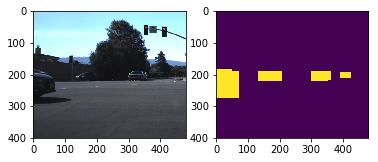

In [7]:
# Test to make sure image and mask look good
plt.subplot(1,2,1)
plt.imshow(X_test[2])

plt.subplot(1,2,2)
plt.imshow(y_test[2][:,:,0])


#### Define Neural Network
#### Credit to https://github.com/jocicmarko/ultrasound-nerve-segmentation.git and Vivek Yadav

In [8]:
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K
    
def unet(imrows,imcols):
    inputs = Input((imrows, imcols,3))

    conv1 = Conv2D(8, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(8, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(16, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=3)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=3)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=3)
    conv8 = Conv2D(16, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=3)
    conv9 = Conv2D(8, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(8, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)
    
    return model

Using TensorFlow backend.


#### Define Loss Function as Sorensen Dice Intersection

In [9]:
### Dice coeff calculation
### https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient for explanation

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    
    return 2*(intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

#### Compile Model

In [10]:
# The rows and columns of your input image shape are passed to the model for creation. 
# This defines the input image size for the Neural Network
imrows = (all_images[0].shape)[0]
imcols = (all_images[0].shape)[1]
model = unet(imrows, imcols)
model.compile(optimizer=Adam(lr=1e-4), 
              loss=dice_coef_loss, metrics=[dice_coef])

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 400, 480, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 400, 480, 8)       224       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 400, 480, 8)       584       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 200, 240, 8)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 200, 240, 16)      1168      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 200, 240, 16)      2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 100, 120, 16)      0         
__________

#### Train Model - Run All Up to Here To Initialize

In [18]:
# Load some weights that were trained previously here
load_pretrained = True
if load_pretrained == True:
     model.load_weights("unet_marathon.h5")

In [ ]:
# Create Two Generators: one for image and one for masks, then feed it the set of images and masks and train
# This allows the use of Keras data augmentation that applies to both the image and its corresponding mask

from keras.preprocessing.image import ImageDataGenerator
import time

BATCH_SIZE = 8
EPOCHS = 2

# we create two instances with the same arguments, include data augmentation
data_gen_args = dict(featurewise_center=False,
                     featurewise_std_normalization=False,
                     rotation_range=15.,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 42
image_datagen.fit(X_train, augment=True, seed=seed)
mask_datagen.fit(y_train, augment=True, seed=seed)

valid_imgen = ImageDataGenerator(**data_gen_args)
valid_maskgen = ImageDataGenerator(**data_gen_args)

image_generator = image_datagen.flow(X_train, batch_size = BATCH_SIZE)
mask_generator = mask_datagen.flow(y_train, batch_size = BATCH_SIZE)

valid_im_generator = valid_imgen.flow(X_test, batch_size = BATCH_SIZE)
valid_mask_generator = valid_maskgen.flow(y_test, batch_size = BATCH_SIZE)

# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)
valid_generator = zip(valid_im_generator,valid_mask_generator)

# Create a checkpoint
ckptfilepath="weights-improvement-{epoch:02d}-{val_loss:.3f}.h5"
model_checkpoint = ModelCheckpoint(ckptfilepath, monitor='val_loss', verbose=1, save_best_only=True)

import sys
t = time.time()
sys.stdout = open('my_keras_output.txt', 'w')
print("Starting time: ",time.ctime())
history = model.fit_generator(
    train_generator,
    steps_per_epoch=2,#len(X_train),
    epochs=EPOCHS,
    validation_data=valid_generator,
    validation_steps=len(X_test),
    callbacks=[model_checkpoint])
print(history.history)
print("walltime: ", time.time()-t)
sys.stdout = sys.__stdout__

#### Save Model

In [ ]:
### Save model and weights
model.save('model_ASK.h5')
model.save_weights("model_weights_ASK.h5", overwrite=True)

#### Testing Model - Run From Here to Test

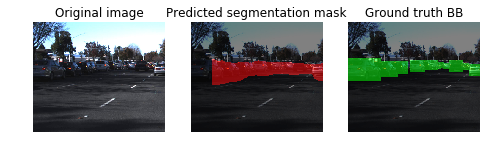

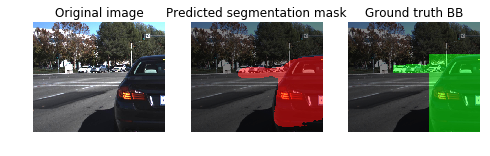

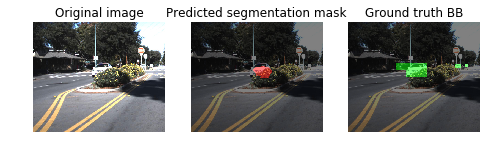

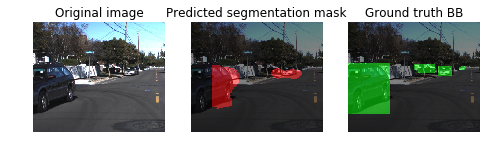

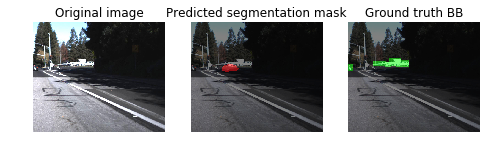

In [12]:
from keras.models import load_model
from keras.models import Model
from keras.optimizers import Adam

reload_model=False
if (reload_model):
    model = load_model('model_ASK.h5')
reload_weights=True
if (reload_weights):
    model.load_weights("model_weights_ASK.h5")
    model.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss, metrics=[dice_coef])
    
gentestnum = 5
batch_img = []
batch_mask = []
pred_all=[]

for i in range(gentestnum):
    i_ = np.random.randint(len(X_test))
    batch_img.append(X_test[i_])
    batch_mask.append(y_test[i_])
    _predimg = np.reshape(batch_img[-1],(1,batch_img[-1].shape[0],batch_img[-1].shape[1],batch_img[-1].shape[2]))
    pred_all.append(model.predict(_predimg)[0,:,:,:])

for i in range(gentestnum):
    # This tests the predicted mask and overlays it on the original image, comparing to the actual mask
    # Most of this plotting/masking code has been borrowed from V. Yadav, thanks!
    #i = np.random.randint(len(batch_img))
    im = np.array(batch_img[i],dtype=np.uint8)
    im_mask = np.array(255*batch_mask[i],dtype=np.uint8)
    im_pred = np.array(255*pred_all[i],dtype=np.uint8)
    
    rgb_mask_pred = cv2.cvtColor(im_pred,cv2.COLOR_GRAY2RGB)
    rgb_mask_pred[:,:,1:3] = 0*rgb_mask_pred[:,:,1:2]
    rgb_mask_true= cv2.cvtColor(im_mask,cv2.COLOR_GRAY2RGB)
    rgb_mask_true[:,:,0] = 0*rgb_mask_true[:,:,0]
    rgb_mask_true[:,:,2] = 0*rgb_mask_true[:,:,2]
    
    img_pred = cv2.addWeighted(rgb_mask_pred,0.5,im,0.5,0)
    img_true = cv2.addWeighted(rgb_mask_true,0.5,im,0.5,0)
    
    plt.figure(figsize=(8,3))
    plt.subplot(1,3,1)
    plt.imshow(im)
    plt.title('Original image')
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(img_pred)
    plt.title('Predicted segmentation mask')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(img_true)
    plt.title('Ground truth BB')
    plt.axis('off')
    plt.show()

#### Define a Vehicle Class

In [13]:
# Define a class to receive the characteristics of each line detection
class Car():
    def refresh(self):        
        while (len(self.recent_box) > self.n):
            self.recent_box.pop(0)                                     
        self.bestbox = np.mean(self.recent_box, axis=0,dtype=int)        
    
    def __init__(self):
        # car detected countdown
        self.detected = 0 
        # box values of the last n predictions
        # Define as (xl,yl,xr,yr)
        self.recent_box = [] 
        #average box values of the fitted line over the last n iterations
        self.bestbox = None
        #center-point for plotting
        self.center = None        
        # Number of iterations n to remember
        self.n = 40


(-0.5, 479.5, 399.5, -0.5)

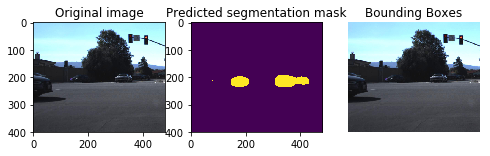

In [14]:
def lum_correct(img):
    # This function uses CLAHE to correct an image for luminosity
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    imcopy = img.copy()
    lab= cv2.cvtColor(imcopy, cv2.COLOR_RGB2LAB)
    l,a,b = cv2.split(lab)

    cl1 = clahe.apply(l)
    equ = cv2.merge((cl1,a,b))
    final = cv2.cvtColor(equ, cv2.COLOR_LAB2RGB)
    
    return final

def pred_heatmap(img):  
    # This function returns a predicted 'heatmap' of where it thinks the cars are, using the model & network above
    #print(img.shape)
    _predimg = np.reshape(img,(1,img.shape[0],img.shape[1],img.shape[2]))
    pred = model.predict(_predimg)[0,:,:,:]
    pred = np.array(pred, dtype=np.uint8)
    #plt.imshow(pred[:,:,0])
    return pred

def label_find(img):
    # This returns a list 'lables' with the image and count of unique fields from the prediction heatmap
    img = img[:,:,0]
    from scipy.ndimage.measurements import label
    labels,num_features = label(img)
    labels = label(img)
    #print("Uniques: ",labels[1])
    #plt.imshow(labels[0], cmap='gray')
    return labels

# Modified from Udacity SDCND Course:
def get_bboxes(labels):
    # Define a minimum detection threshold in pixels:
    boxthresh = 400    
    bbox = []
    
    # Iterate through all detected cars and calculate the bounding box    
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        if (np.count_nonzero(nonzero)>boxthresh):
            #print("Size of nonzero:",np.count_nonzero(nonzero))
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define Margin to correct for NN offset
            margintop = 0.02
            marginleft = 0.02   
            # Define a bounding box based on min/max x and y
            xl = int(np.min(nonzerox)*(1-marginleft))
            yl = int(np.min(nonzeroy)*(1-margintop))
            xr = int(np.max(nonzerox)*(1-marginleft))
            yr = int(np.max(nonzeroy)*(1-margintop))

            bbox.append([xl,yl,xr,yr])        
    return bbox

def cardistance(center1,center2):
    # Gives the Euclidian distance between 2 center points
    from scipy.spatial import distance
    dst = distance.euclidean(center1,center2)
    return dst

def carinbox(newbox, bestbox):
    # Determines if a detected bounding box is within another box, with some margin
    # Helps with irregular detections near the same box
    boxmarg = 0.1 # Extra space around existing bounding box
    if (newbox[0]>bestbox[0]*(1-boxmarg)) & (newbox[2]<bestbox[2]*(1+boxmarg)) & (newbox[1]>bestbox[1]*(1-boxmarg)) & (newbox[3]<bestbox[3]*(1+boxmarg)):
        #print("found in box")
        return True
    else:
        return False

def draw_bboxes(image, CarList, bbox):
    # Draws bounding boxes from the CarList with some Sanity Checks

    # Establish proximity for car boxes in pixels used in merging:
    carthresh = 150
    # Establish how many frames a car should last:
    car_countdown = 1
    
    for box in bbox:
        centerxy = (int(0.5*(box[2] + box[0])),int(0.5*(box[3] + box[1])))
        #print(centerxy)
        #img = cv2.circle(img, centerxy, 5, (255,0,0), 6)
        if len(CarList)==0:
            #print("firstcar")
            carnew = Car()
            carnew.detected = car_countdown
            carnew.center = centerxy
            carnew.recent_box.append(box)
            carnew.refresh()
            CarList.append(carnew)
        else:
            isnewcar = False;
            for car in CarList:
                # If the new car center is within an existing center, merge cars
                if (cardistance(car.center,centerxy)<carthresh):
                    car.center = centerxy
                    car.recent_box.append(box)
                    car.detected = car.detected+1.2
                    car.refresh()                    
                else:
                    isnewcar = True
            # If this a new car, add it to the CarList
            if (isnewcar):
                carnew = Car()
                carnew.detected = car_countdown
                carnew.center = centerxy
                carnew.recent_box.append(box)
                carnew.refresh()
                CarList.append(carnew)

    # Use an image copy, good for debugging, but could be changed for memory optimization
    img_boxed = image.copy()
    
    # Perform some sanity checks on the carlist. Remove cars that have 'expired' i.e. car.detected < 0
    # Also compare to other cars in the list and merge if they are within a threshold, or within an existing box.
    
    for ind1, car in enumerate(CarList):    
        car.detected = car.detected - 1
        if (car.detected<=0):
            #print("removing")
            CarList.remove(car)
        else:
            for ind2, othercar in enumerate(CarList):
                if carinbox(othercar.bestbox, car.bestbox)&(ind1!=ind2):
                    #print("removing from list")
                    CarList.remove(othercar)
            for ind2, othercar in enumerate(CarList):
                #Compare centers, and not to itself                
                if (cardistance(othercar.center,car.center)<carthresh)&(ind1!=ind2):
                    car.recent_box = car.recent_box + othercar.recent_box
                    car.bestbox = np.mean(car.recent_box, axis=0,dtype=int)
                    CarList.remove(othercar)
            # Draw and return the bounding boxes for all cars in the list
            bbox1 = (car.bestbox[0],car.bestbox[1])
            bbox2 = (car.bestbox[2],car.bestbox[3])
            img_boxed = cv2.rectangle(image, bbox1, bbox2, (0,0,255), 6)
    return img_boxed

# Test the functions above
img = X_test[2].copy()

img_pred = pred_heatmap(lum_correct(img))
labels = label_find(img_pred)

CarList = []
bbox = get_bboxes(labels)
img_boxed = draw_bboxes(img,CarList,bbox)

plt.figure(figsize=(8,3))
plt.subplot(1,3,1)
plt.imshow(img)
plt.title('Original image')
plt.axis('on')
plt.subplot(1,3,2)
plt.imshow(img_pred[:,:,0])
plt.title('Predicted segmentation mask')
plt.axis('on')
plt.subplot(1,3,3)
plt.imshow(img_boxed)
plt.title('Bounding Boxes')
plt.axis('off')


#### Process Pipeline

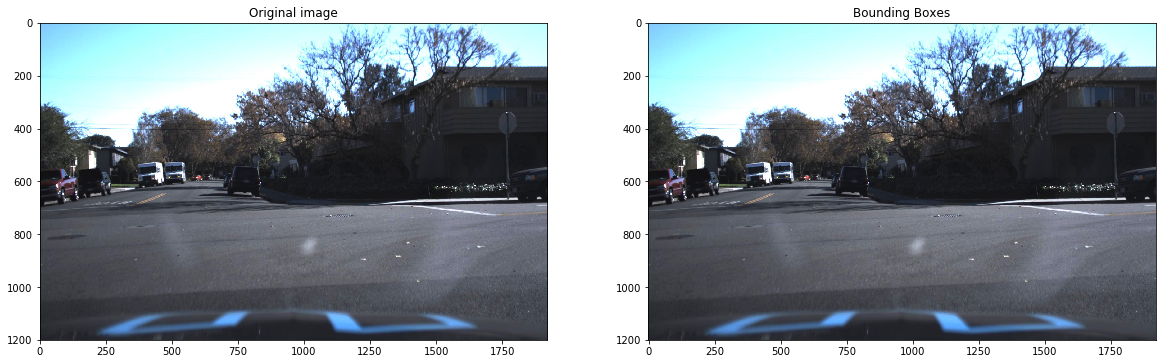

In [15]:
def bbox_pipeline(image):
    # This bounding box pipeline takes in a full size dashcam image, performs the scaling and mask detection
    # Then upscales the detected mask image before passing to the label and bounding box functions.
    # This allows for any input image size to be analyzed for vehicles using the model.
    input_image_size = (1920,1200) # Hardcoded from input source, future work would make this dynamic
    #print(image.shape)
    image = cv2.resize(image,input_image_size,interpolation = cv2.INTER_CUBIC)
    #print("Orig Size:",image.shape)
    orig_image = image.copy()
    
    # These parameters should match how the model was trained and split above
    xsplit = 2
    scale = 0.5
    ylow = 0.125
    yfrac = 2/3
    
    # Initialize the left and right images list
    images = []
    img_size = np.shape(image)
    
    # Scale the input image to match the same ratio as the trained model
    image = cv2.resize(image,(int(scale*img_size[1]), int(scale*img_size[0])), interpolation = cv2.INTER_CUBIC)
    img_size = np.shape(image)
    
    # Split the images and add it to the list of images
    for i in range(xsplit):
        img_slice = image[int(img_size[0]*(1-(yfrac+ylow))):int(img_size[0]*(1-ylow)),
                            int(i*img_size[1]/xsplit):int((i*img_size[1]/xsplit)+img_size[1]/xsplit)]
        images.append(img_slice)
    
    # Perform a prediction on each Left & Right slice, and then merge together again horizontally
    img_pred = np.hstack((pred_heatmap(lum_correct(images[0])),pred_heatmap(lum_correct(images[1]))))
    
    # Make sure to pad the predicted mask to match the original image before it was sliced out
    # top, bottom, left, right - border width in number of pixels in corresponding directions
    top = int(img_size[0]*(1-(yfrac+ylow)))
    bottom =  int(img_size[0]*ylow)    
    img_pred = cv2.copyMakeBorder(img_pred,top,bottom,0,0,cv2.BORDER_CONSTANT,value=0)
    
    img_size = np.shape(img_pred)
    
    # Rescale the image to the original size
    img_pred = cv2.resize(img_pred,(int((1/scale)*img_size[1]), int((1/scale)*img_size[0])), interpolation = cv2.INTER_CUBIC)
    img_pred = np.reshape(img_pred,(img_pred.shape[0],img_pred.shape[1],1))
    
    # Now that it is rescaled, label the images, get bounding boxes, and draw bounding boxes
    labels = label_find(img_pred)
    bbox = get_bboxes(labels)    
    img_boxed = draw_bboxes(orig_image,CarList,bbox)       
    
    # Return original scale image with bounding boxes on them
    return img_boxed

# Testing the pipeline
# IMPORTANT: have to adjust smoothing parameters for the bounding boxes if you want to see a single image.
# This is because the smoothing parameters ignore single frame bounding boxes to minimize false positives.

file_name = df_vehicle['File_Path'][10]
test_pipeline = cv2.cvtColor(cv2.imread(file_name),cv2.COLOR_BGR2RGB)

CarList = []

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(test_pipeline)
plt.title('Original image')
plt.subplot(1,2,2)
plt.imshow(bbox_pipeline(test_pipeline))
plt.title('Bounding Boxes')



#### Process Movie

In [16]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

CarList = []

white_output = 'my_test.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(bbox_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video my_test.mp4
[MoviePy] Writing video my_test.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [02:23<00:00,  8.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: my_test.mp4 

Wall time: 2min 25s


#### Display Movie

In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))